# **Predviđanje otkaza zaposlenih pomoću različitih metoda binarne klasifikacije**

SV 25/2022
## Uvod

Cilj ovog projekta je predviđanje
otkaza zaposlenih pomoću različitih metoda analize podataka.
Podaci o zaposlenima uključuju različite faktore kao što su nivo obrazovanja,
radni staž, lokacija u kojoj su zaposleni, nivo plate... Cilj je razviti modele koji
su sposobni da predviđaju moguće otkaze zaposlenih na osnovu ovih podataka.
Postoje mnogi modeli koji mogu biti korisni za rešavanje ovog problema.
Ovaj rad će se pretežno baviti korišćenjem modela Logistic Regression, Decision
Tree, Random Forests i Extreme Gradient Boosting, kako bi se postiglo što
uspešnije predviđanje otkaza.


Podaci su sačinjeni od 9 kolona (atributa) i 4563 reda. Kolona čija se vrednost
treba predvideti je LeaveOrNot koja ukazuje na to da li zaposleni napušta
firmu.

### Biblioteke i podaci nad kojima se vrsi predikcija

In [593]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score
from xgboost import plot_importance


In [594]:
df = pd.read_csv("Employee.csv")
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [596]:
print(df.columns[df.isnull().any()])

Index([], dtype='object')


Podaci govore o 4653 zaposlena i sve vrednosti su ispravno unete.

# Vizuelizacija podataka


Potrebno je vizualizovati podatke s kojima se radi, kako bi se mogli izvući zaključci na osnovu posmatranih podataka.

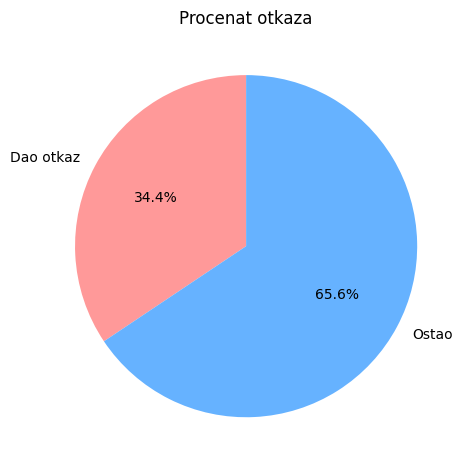

In [597]:
left_percentage = (df['LeaveOrNot'].sum() / len(df)) * 100
not_left_percentage = 100 - left_percentage

vrednosti = ['Dao otkaz', 'Ostao']

values = [left_percentage, not_left_percentage]

boje = ['#FF9999', '#66B2FF']

plt.pie(values, labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Procenat otkaza')

plt.tight_layout()
plt.show()


### Uticaj privremene besposlice

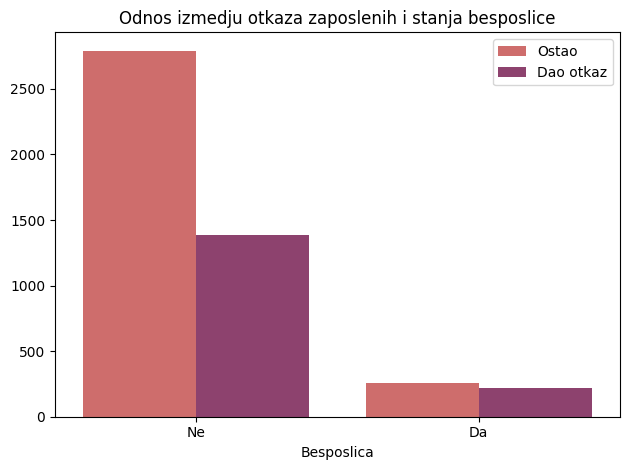

In [598]:
ax = sns.countplot(x='EverBenched', hue='LeaveOrNot', data=df, palette='flare')

ax.legend( labels=['Ostao', 'Dao otkaz'])

ax.set_xlabel('Besposlica')  
ax.set_ylabel('')  
ax.set_xticks([0, 1])
ax.set_xticklabels(['Ne', 'Da'])

plt.title('Odnos izmedju otkaza zaposlenih i stanja besposlice')
plt.tight_layout()
plt.show()

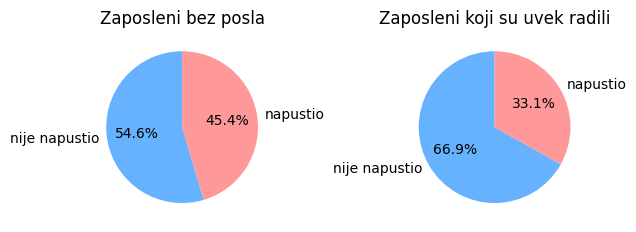

In [599]:
count_table = pd.crosstab(index=df['EverBenched'], columns=df['LeaveOrNot'])

left_not_left_benched = count_table.loc['Yes'].tolist()
left_not_left_not_benched = count_table.loc['No'].tolist()

vrednosti = ["nije napustio", "napustio"]

boje = ['#66B2FF','#FF9999']

plt.subplot(1, 2, 1)
plt.pie(left_not_left_benched, labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Zaposleni bez posla')

plt.subplot(1, 2, 2)
plt.pie(left_not_left_not_benched, labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Zaposleni koji su uvek radili')

plt.tight_layout()

plt.show()


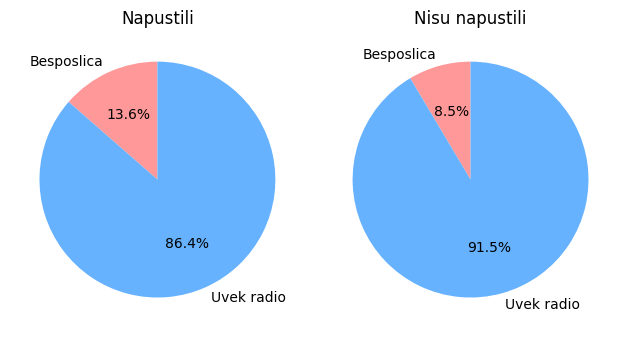

In [600]:
count_table = pd.crosstab(index=[df['LeaveOrNot'], df['EverBenched']], columns='count')


left_benched_not_benched = count_table.loc[(1, 'Yes'), 'count'].tolist()
left_not_benched_not_benched = count_table.loc[(1, 'No'), 'count'].tolist()
not_left_benched_not_benched = count_table.loc[(0, 'Yes'), 'count'].tolist()
not_left_not_benched_not_benched = count_table.loc[(0, 'No'), 'count'].tolist()


vrednosti = ['Besposlica', 'Uvek radio']

boje = ['#FF9999', '#66B2FF']

plt.subplot(1, 2, 1)
plt.pie([left_benched_not_benched, left_not_benched_not_benched], labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Napustili')

plt.subplot(1, 2, 2)
plt.pie([not_left_benched_not_benched, not_left_not_benched_not_benched], labels=vrednosti, colors=boje, autopct='%1.1f%%', startangle=90)
plt.title('Nisu napustili')

plt.tight_layout()

plt.show()



Iz podataka se vidi kako su radnici koji su uvek imali posla naklonjeniji da ostanu.

### Raspodela polova

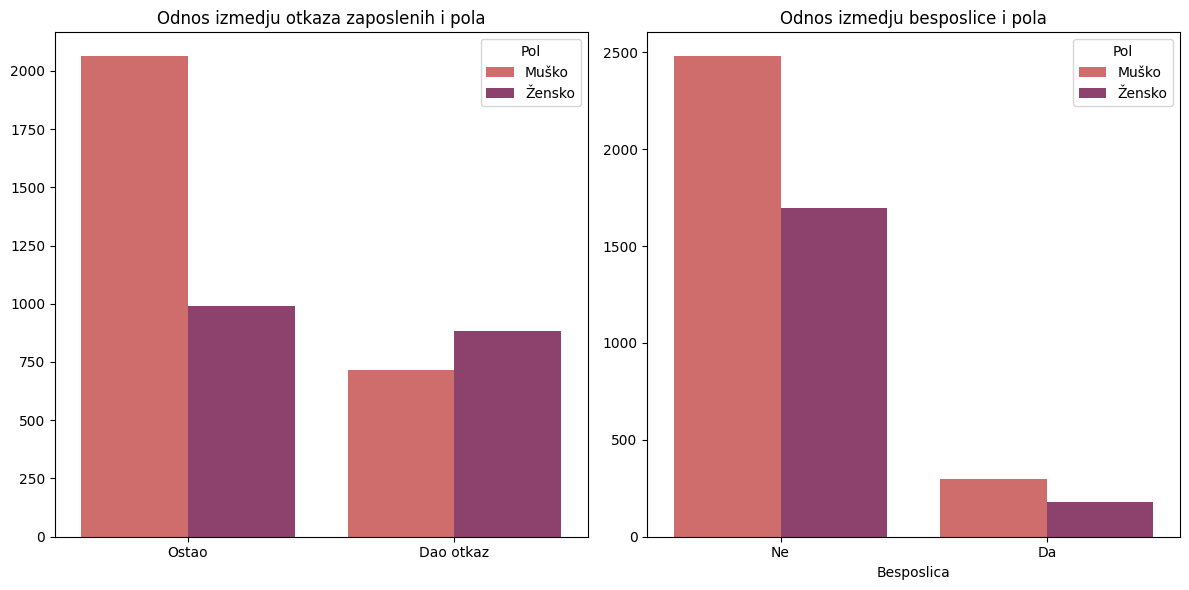

In [601]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='LeaveOrNot', hue='Gender', data=df, palette='flare')
plt.title('Odnos izmedju otkaza zaposlenih i pola')
ax1.legend(title='Pol', labels=['Muško', 'Žensko'])

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Ostao', 'Dao otkaz'])


plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='EverBenched', hue='Gender', data=df, palette='flare')
plt.title('Odnos izmedju besposlice i pola')
ax2.legend(title='Pol', labels=['Muško', 'Žensko'])

ax2.set_xlabel('Besposlica')
ax2.set_ylabel('')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Ne', 'Da'])

plt.tight_layout()
plt.show()

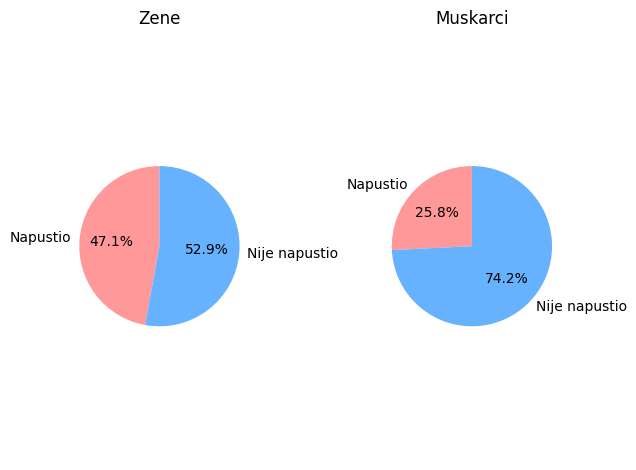

In [602]:
female_employees = df[df['Gender'] == 'Female']
male_employees = df[df['Gender'] == 'Male']

total_female = len(female_employees)
left_female = len(female_employees[female_employees['LeaveOrNot'] == 1])
not_left_female = total_female - left_female

total_male = len(male_employees)
left_male = len(male_employees[male_employees['LeaveOrNot'] == 1])
not_left_male = total_male - left_male

fig, axs = plt.subplots(1, 2)

axs[0].pie([left_female, not_left_female], labels=['Napustio', 'Nije napustio'], colors=boje,
           autopct='%1.1f%%', startangle=90)
axs[0].set_title('Zene')

axs[1].pie([left_male, not_left_male], labels=['Napustio', 'Nije napustio'], colors=boje,
           autopct='%1.1f%%', startangle=90)
axs[1].set_title('Muskarci')

axs[0].axis('equal')
axs[1].axis('equal')
plt.tight_layout()
plt.show()

Sa grafika se može zaključiti da žene mnogo češće daju otkaz od muškaraca.

### Raspodela godina

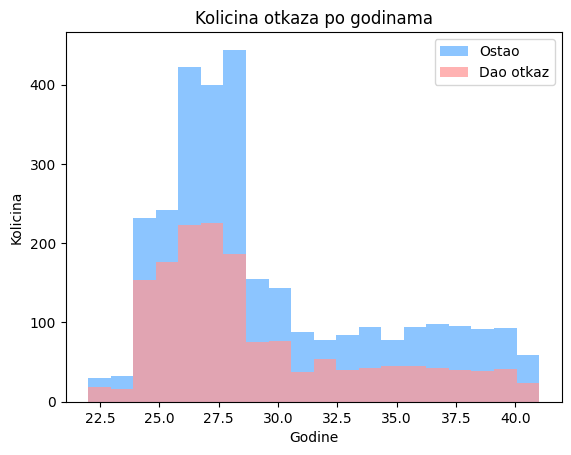

In [603]:
plt.figure()
plt.hist(df[df['LeaveOrNot'] == 0]['Age'], alpha=0.75, label='Ostao', bins=20,color=boje[1])
plt.hist(df[df['LeaveOrNot'] == 1]['Age'], alpha=0.75, label='Dao otkaz', bins=20,color=boje[0])
plt.xlabel('Godine')
plt.ylabel('Kolicina')
plt.legend()
plt.title('Kolicina otkaza po godinama')
plt.show()


<Figure size 1500x600 with 0 Axes>

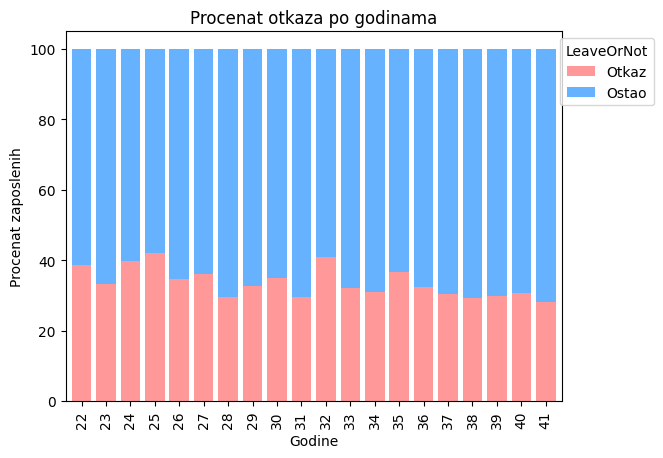

In [604]:
plt.figure(figsize=(15, 6))
percentage_leave_by_age.plot(kind='bar', stacked=True, color=['#FF9999', '#66B2FF'], width=0.8)


plt.xlabel('Godine')
plt.ylabel('Procenat zaposlenih')
plt.title('Procenat otkaza po godinama')


plt.legend(title='LeaveOrNot', labels=['Otkaz', 'Ostao'], loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

### Uticaj plate i nivoa obrazovanja

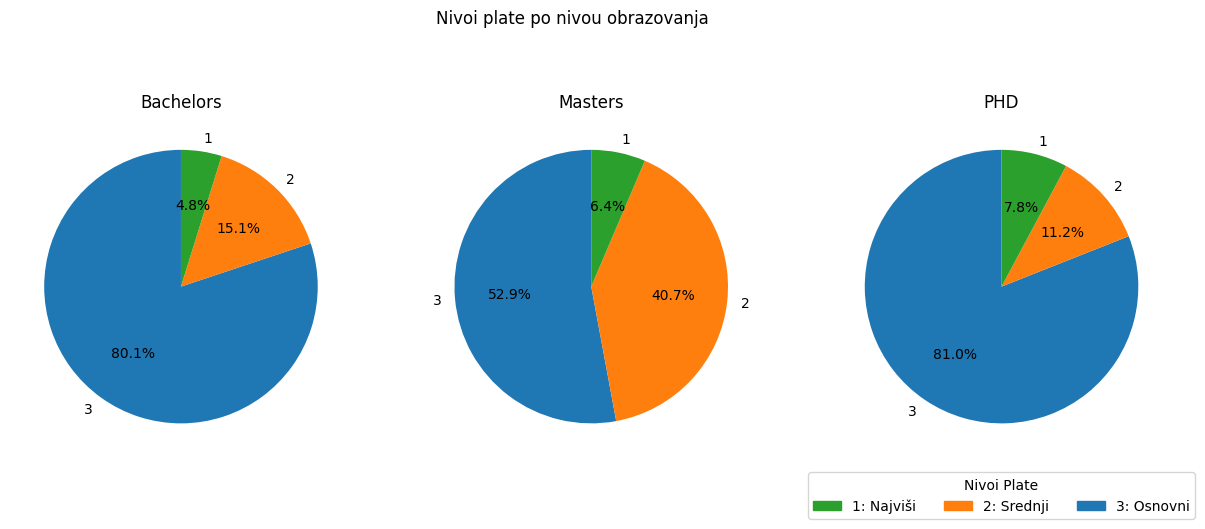

In [605]:
education_levels = df['Education'].unique()

fig, axs = plt.subplots(1, len(education_levels), figsize=(15, 5))

payment_tier_labels = {1: 'Najviši', 2: 'Srednji', 3: 'Osnovni'}
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

for i, education_level in enumerate(education_levels):
    subset = df[df['Education'] == education_level]
    payment_tier_counts = subset['PaymentTier'].value_counts()

    axs[i].pie(payment_tier_counts, labels=payment_tier_counts.index, autopct='%1.1f%%', startangle=90, colors=default_colors)
    axs[i].set_title(f'{education_level}')

default_colors[0], default_colors[2] = default_colors[2], default_colors[0]


handles = [plt.Rectangle((0,0),1,1, color=default_colors[i], label=f'{key}: {payment_tier_labels[key]}') for i, key in enumerate(payment_tier_labels.keys())]
plt.legend(handles=handles, title='Nivoi Plate', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(payment_tier_labels))

plt.suptitle('Nivoi plate po nivou obrazovanja', y=1.05)
plt.show()

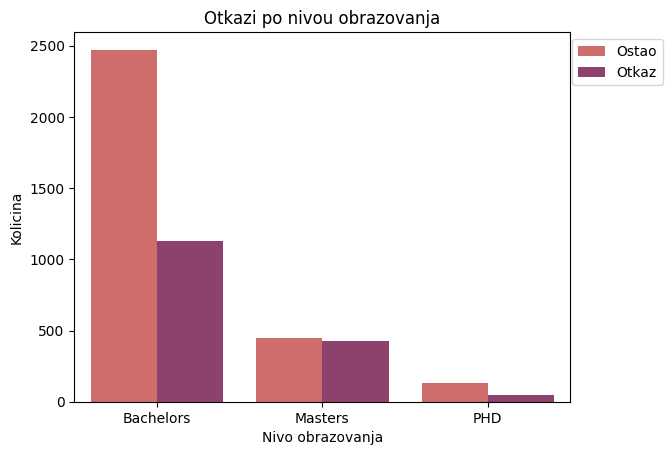

In [606]:
plt.figure()
ax = sns.countplot(x='Education', hue='LeaveOrNot', data=df, palette='flare')

ax.set_xticks(range(len(df['Education'].unique())))
ax.set_xticklabels(['Bachelors', 'Masters', 'PHD'])

plt.xlabel('Nivo obrazovanja')
plt.ylabel('Kolicina')
plt.title('Otkazi po nivou obrazovanja')
plt.legend(labels=['Ostao', 'Otkaz'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

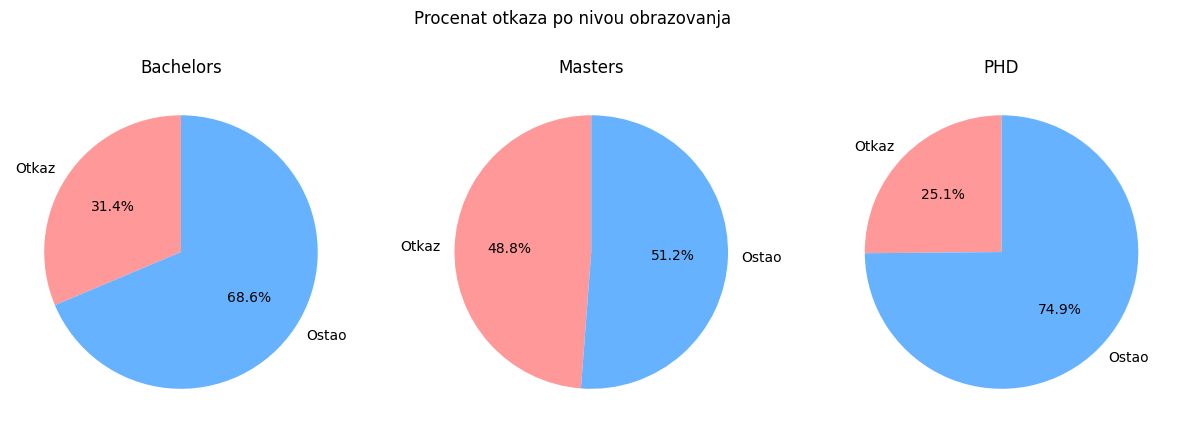

In [607]:
education_leave_percentage = df.groupby('Education')['LeaveOrNot'].mean() * 100

fig, axs = plt.subplots(1, len(education_leave_percentage), figsize=(15, 5))

for i, (education, percentage) in enumerate(education_leave_percentage.items()):
    axs[i].pie([percentage, 100 - percentage], labels=['Otkaz', 'Ostao'], autopct='%1.1f%%', startangle=90,
        colors=['#FF9999','#66B2FF'])
    axs[i].set_title(f'{education}')

plt.suptitle('Procenat otkaza po nivou obrazovanja')
plt.show()

Vidi se da skoro polovina zaposlenih sa masterom odlučuje da napusti firmu.

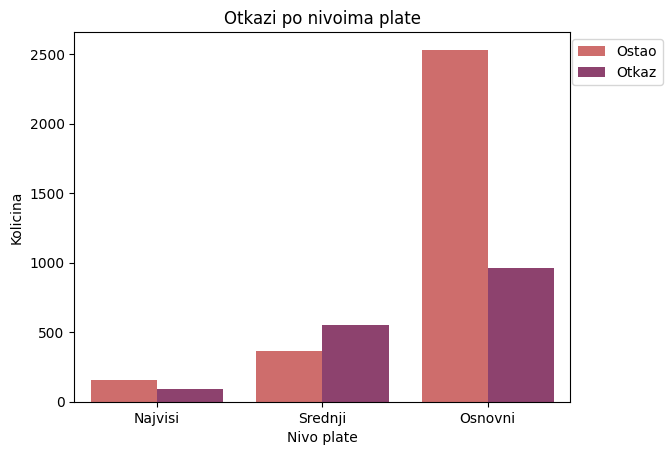

In [608]:
plt.figure()
ax = sns.countplot(x='PaymentTier', hue='LeaveOrNot', data=df, palette='flare')

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Najvisi', 'Srednji', 'Osnovni'])

plt.xlabel('Nivo plate')
plt.ylabel('Kolicina')
plt.title('Otkazi po nivoima plate')
plt.legend(labels=['Ostao', 'Otkaz'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

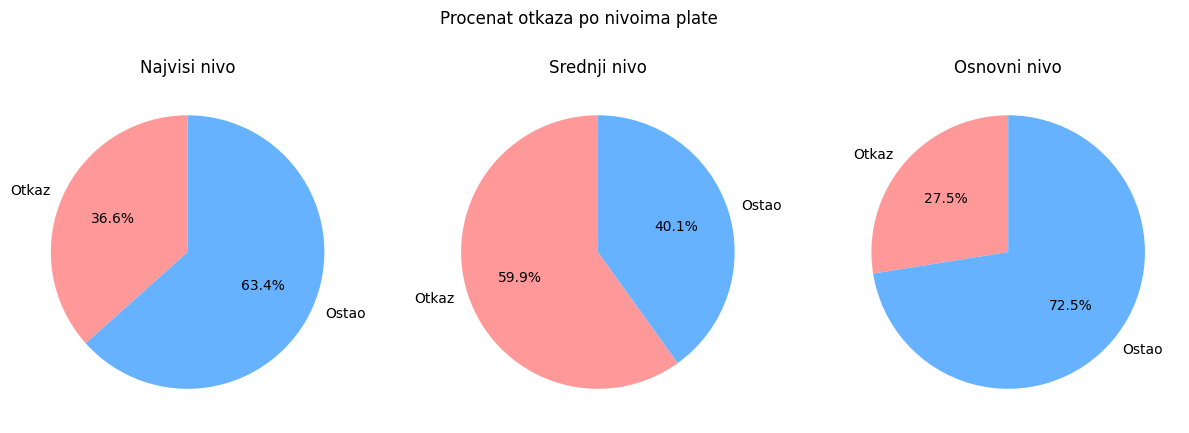

In [609]:
payment_tier_leave_percentage = df.groupby('PaymentTier')['LeaveOrNot'].mean() * 100

fig, axs = plt.subplots(1, len(payment_tier_leave_percentage), figsize=(15, 5))
payment_tier_titles = {1: 'Najvisi nivo', 2: 'Srednji nivo', 3: 'Osnovni nivo'}

for i, (payment_tier, percentage) in enumerate(payment_tier_leave_percentage.items()):
    axs[i].pie([percentage, 100 - percentage], labels=['Otkaz', 'Ostao'], autopct='%1.1f%%', startangle=90,
        colors=['#FF9999', '#66B2FF'])
    axs[i].set_title(payment_tier_titles[payment_tier])

plt.suptitle('Procenat otkaza po nivoima plate')
plt.show()

Čak 60% zaposlenih koji su imali srednji nivo plate odlučili su se za otkaz.

### Uticaj godina rada u firmi

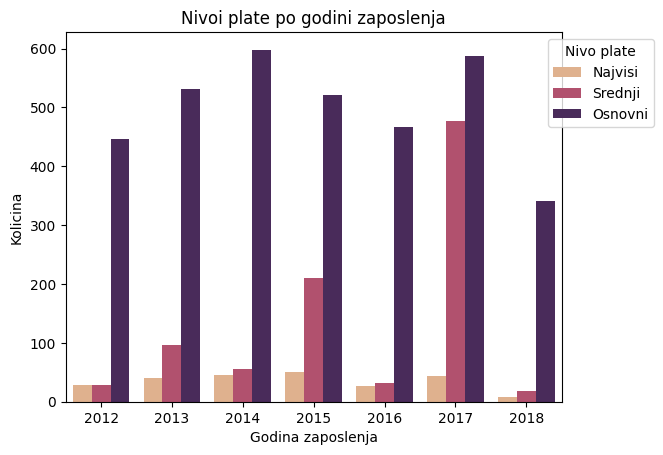

In [610]:
plt.figure()
sns.countplot(x='JoiningYear', hue='PaymentTier', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Kolicina')
plt.title('Nivoi plate po godini zaposlenja')
plt.legend(title = "Nivo plate",labels=['Najvisi','Srednji', 'Osnovni'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

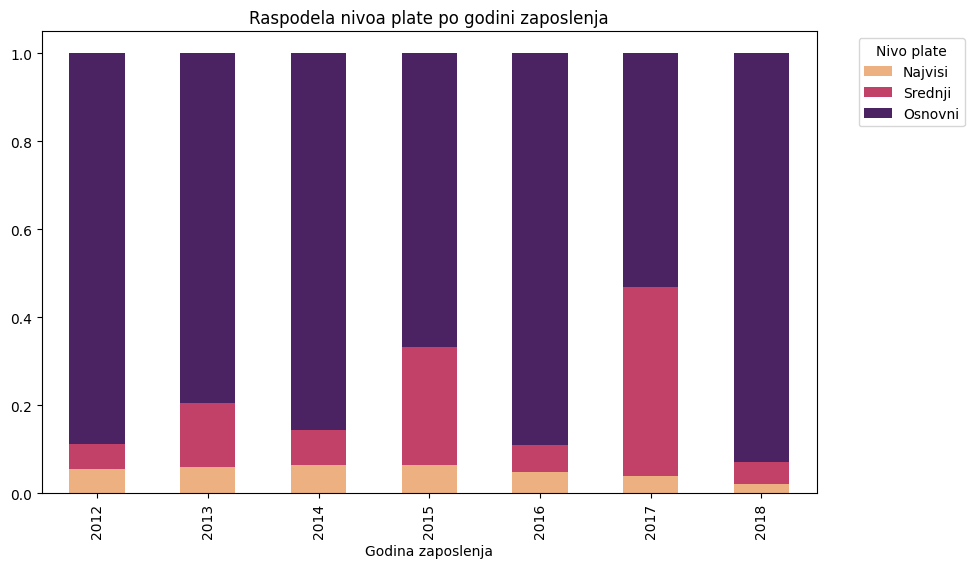

In [611]:
payment_tier_distribution = df.groupby(['JoiningYear', 'PaymentTier']).size().unstack().apply(lambda x: x / x.sum(), axis=1)

payment_tier_distribution.plot(kind='bar', stacked=True, colormap='flare', figsize=(10, 6))

plt.xlabel('Godina zaposlenja')
plt.title('Raspodela nivoa plate po godini zaposlenja')
plt.legend(title = "Nivo plate",labels=['Najvisi','Srednji', 'Osnovni'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

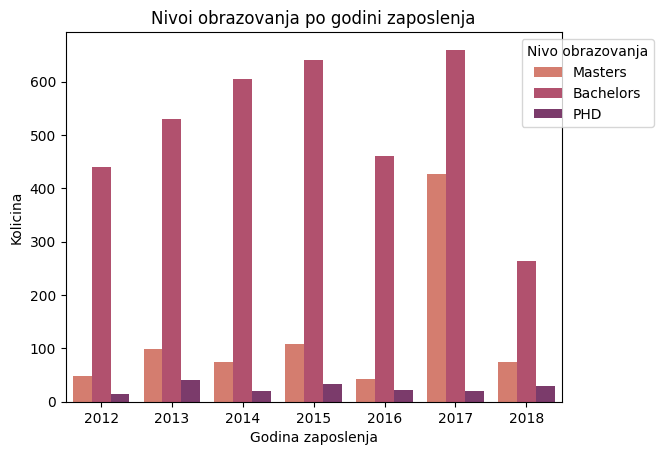

In [612]:
plt.figure()
sns.countplot(x='JoiningYear', hue='Education', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Kolicina')
plt.title('Nivoi obrazovanja po godini zaposlenja')
plt.legend(title='Nivo obrazovanja', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show() #group by 2017 i master (i Puna)

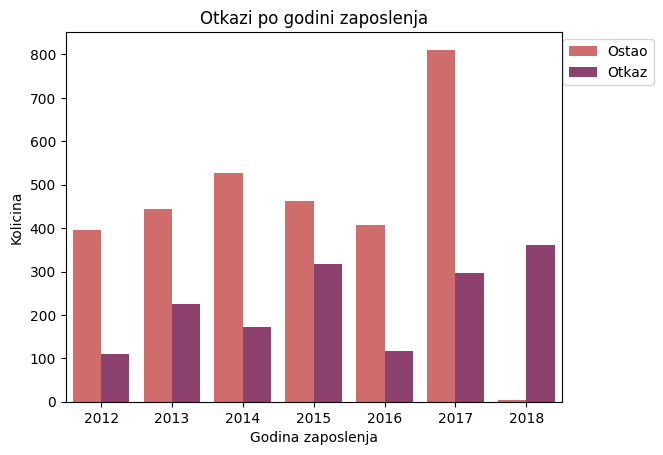

In [613]:
plt.figure()
sns.countplot(x='JoiningYear', hue='LeaveOrNot', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Kolicina')
plt.title('Otkazi po godini zaposlenja')
plt.legend(labels=['Ostao', 'Otkaz'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

<Figure size 640x480 with 0 Axes>

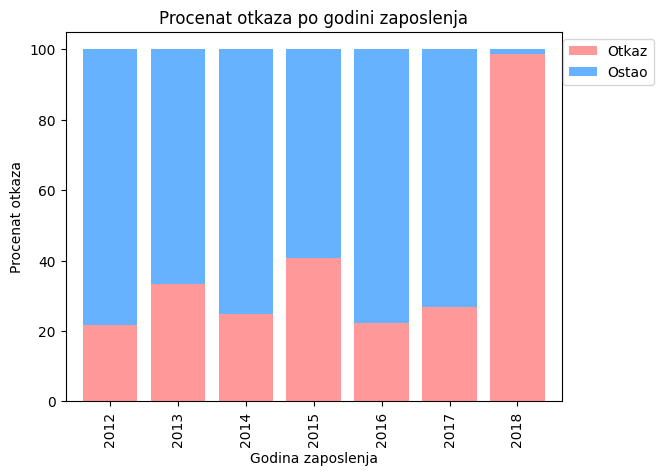

In [614]:
percentage_leave_by_year = df.groupby(['JoiningYear', 'LeaveOrNot']).size().unstack().div(df.groupby('JoiningYear').size(), axis=0) * 100
percentage_leave_by_year[0] = 100 - percentage_leave_by_year[1].fillna(0)

percentage_leave_by_year = percentage_leave_by_year.loc[:, ::-1]

plt.figure()
percentage_leave_by_year.plot(kind='bar', stacked=True, color=['#FF9999','#66B2FF'], width=0.8)

plt.xlabel('Godina zaposlenja')
plt.ylabel('Procenat otkaza')
plt.title('Procenat otkaza po godini zaposlenja')
plt.legend(labels=['Otkaz', 'Ostao'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

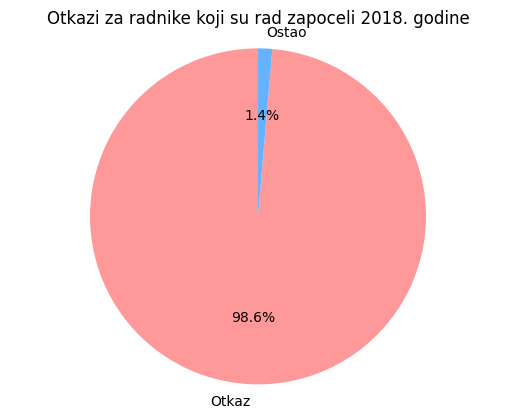

In [615]:
joined_2018_employees = df[df['JoiningYear'] == 2018]

leave_not_leave_counts = joined_2018_employees['LeaveOrNot'].value_counts()
plt.figure()
plt.pie(leave_not_leave_counts, labels=["Otkaz","Ostao"], autopct='%1.1f%%', startangle=90,
        colors=['#FF9999', '#66B2FF'])
plt.title('Otkazi za radnike koji su rad zapoceli 2018. godine')
plt.axis('equal') 
plt.show()

Grafik prikazuje kako su skoro svi zaposleni koji su se pridruzili kompaniji 2018. godine dali otkaz.

### Lokacija zaposlenih

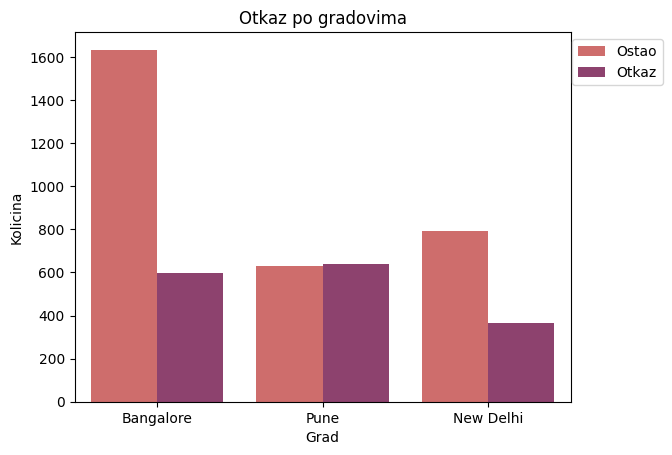

In [616]:
plt.figure()
sns.countplot(x='City', hue='LeaveOrNot', data=df, palette='flare')
plt.xlabel('Grad')
plt.ylabel('Kolicina')
plt.title('Otkaz po gradovima')
plt.legend(labels=['Ostao', 'Otkaz'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

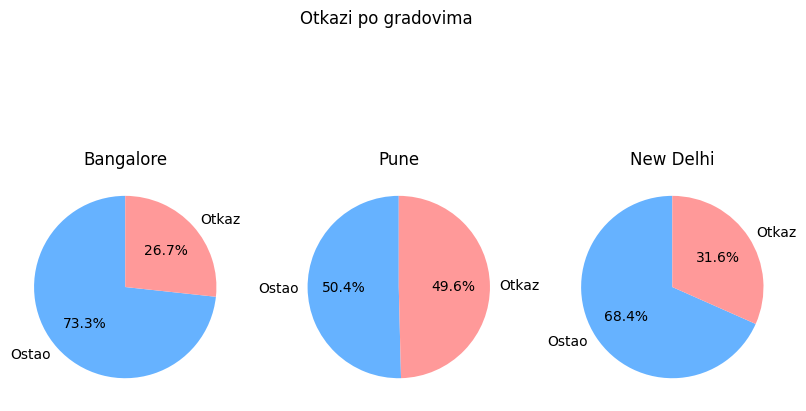

In [617]:
cities = df['City'].unique()

fig, axs = plt.subplots(1, len(cities), figsize=(10, 5))

for i, city in enumerate(cities):
    subset = df[df['City'] == city]
    leave_counts = subset['LeaveOrNot'].value_counts()

    axs[i].pie(leave_counts, labels=["Ostao","Otkaz"],colors=['#66B2FF','#FF9999'], autopct='%1.1f%%', startangle=90)
    axs[i].set_title(f'{city}')

plt.suptitle('Otkazi po gradovima', y=1.05)
plt.show()

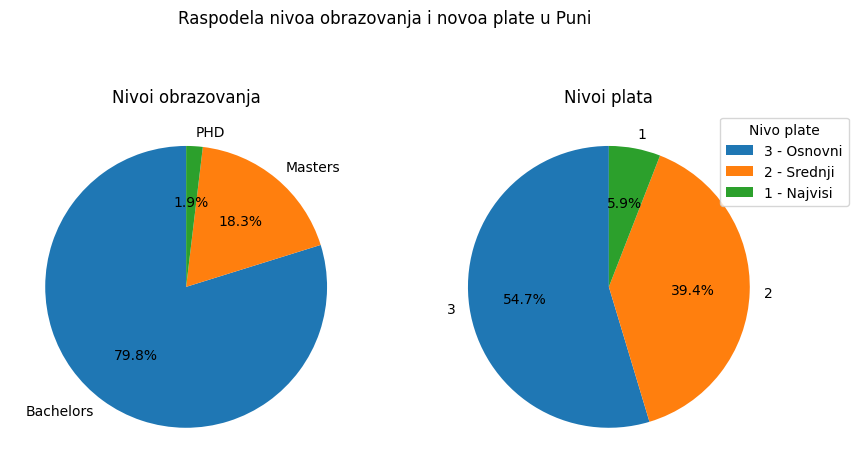

In [618]:
pune_data = df[df['City'] == 'Pune']


fig, axs = plt.subplots(1, 2, figsize=(10, 5))


education_counts = pune_data['Education'].value_counts()
axs[0].pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
axs[0].set_title('Nivoi obrazovanja')


payment_tier_counts = pune_data['PaymentTier'].value_counts()
pie2 = axs[1].pie(payment_tier_counts, labels=payment_tier_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
axs[1].set_title('Nivoi plata')


legend_labels = {1: 'Najvisi', 2: 'Srednji', 3: 'Osnovni'}
axs[1].legend(pie2[0], [f'{key} - {legend_labels[key]}' for key in reversed(legend_labels)], title='Nivo plate', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.suptitle('Raspodela nivoa obrazovanja i nivoa plate u Puni', y=1.05)
plt.show()

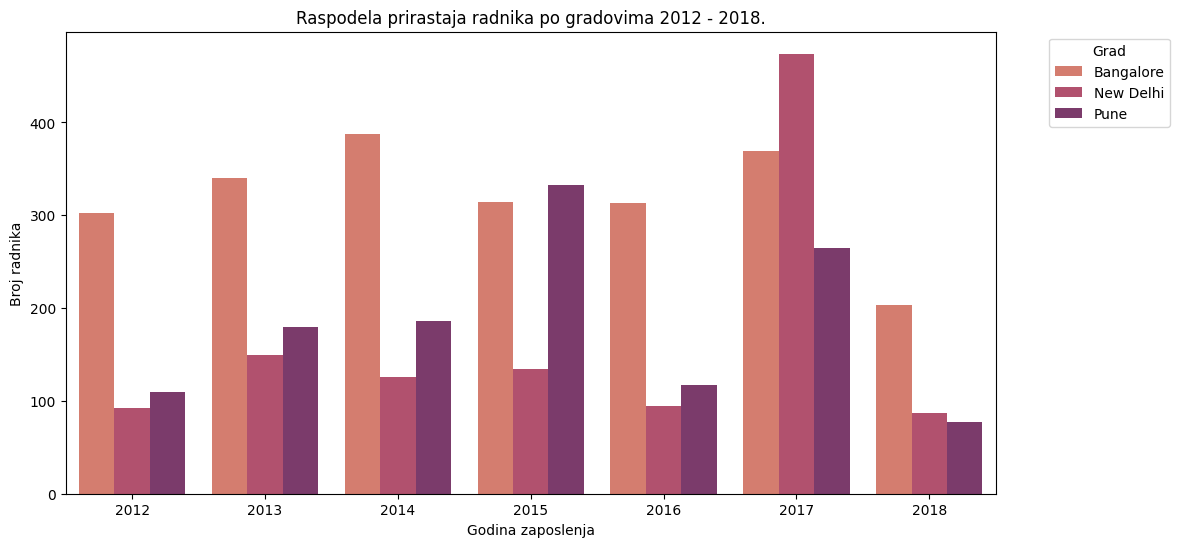

In [619]:
plt.figure(figsize=(12, 6))
sns.countplot(x='JoiningYear', hue='City', data=df, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Broj radnika')
plt.title('Raspodela prirastaja radnika po gradovima 2012 - 2018.')
plt.legend(title='Grad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

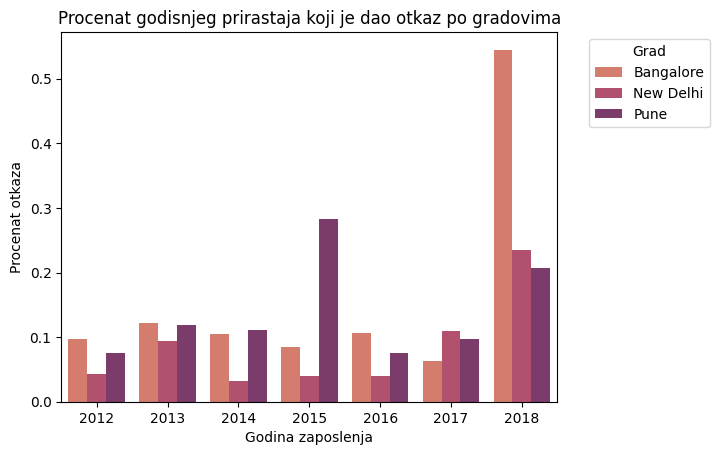

In [620]:
joined_left = df[df['LeaveOrNot'] == 1]

df_percentages = (joined_left.groupby(['JoiningYear', 'City']).size() / df.groupby('JoiningYear').size()).reset_index(name='Percentage')

plt.figure()
sns.barplot(x='JoiningYear', y='Percentage', hue='City', data=df_percentages, palette='flare')
plt.xlabel('Godina zaposlenja')
plt.ylabel('Procenat otkaza')
plt.title('Procenat godisnjeg prirastaja koji je dao otkaz po gradovima')
plt.legend(title='Grad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show() #naslov promeniti u nesto citljivije


Zaposleni su najzadovoljniji u Nju Delhiju, dok su najnezadovoljniji radnici koji su se zaposlili 2018. godine u Bangaloru. Uopšte, najnezadovoljniji su radnici iz Puna i Bangalora, pri čemu Pune ima najveći procenat otkaza usled nezadovoljstva radnika koji su se zaposlili 2015. godine, što je bio drugi najveći godišnji prirastaj radnika posle 2017. godine.

### Uticaj iskustva u struci na otkaz zaposlenog

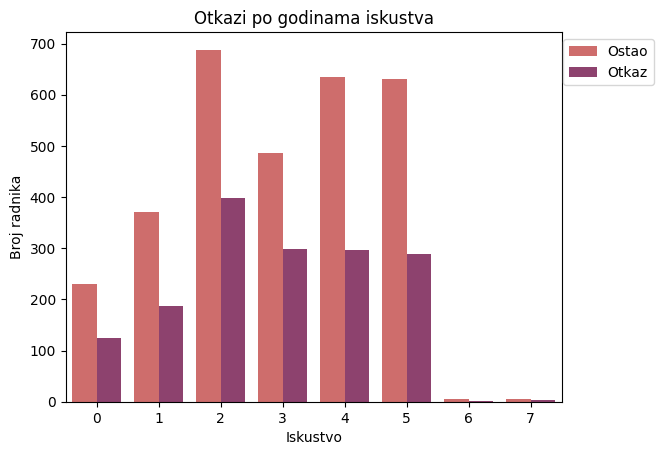

In [621]:
plt.figure()
sns.countplot(x='ExperienceInCurrentDomain', hue='LeaveOrNot', data=df, palette='flare')
plt.xlabel('Iskustvo')
plt.ylabel('Broj radnika')
plt.title('Otkazi po godinama iskustva')
plt.legend(labels=['Ostao', 'Otkaz'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

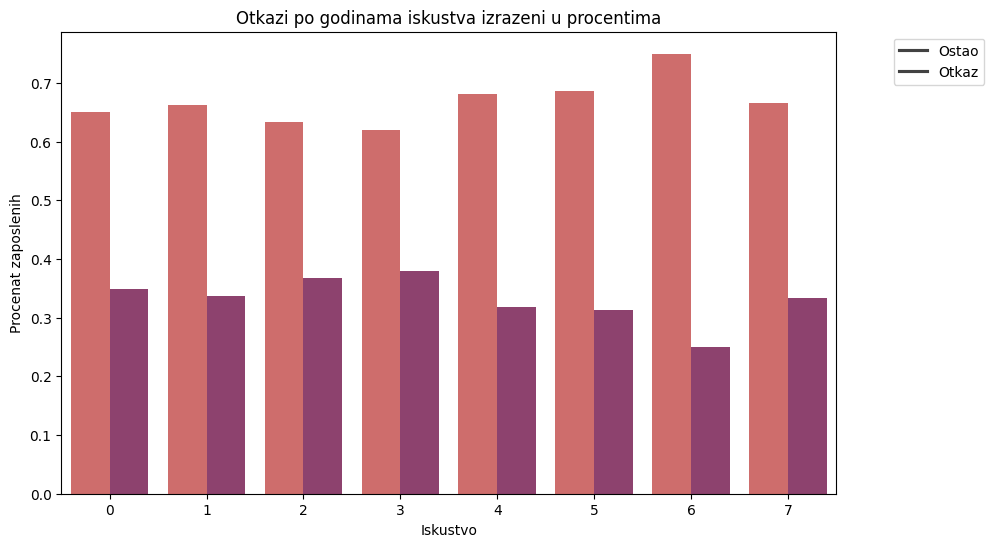

In [622]:
df_percentages = (df.groupby(['ExperienceInCurrentDomain', 'LeaveOrNot']).size() / df.groupby('ExperienceInCurrentDomain').size()).reset_index(name='Percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='ExperienceInCurrentDomain', y='Percentage', hue='LeaveOrNot', data=df_percentages, palette='flare')
plt.xlabel('Iskustvo')
plt.ylabel('Procenat zaposlenih')
plt.title('Otkazi po godinama iskustva izrazeni u procentima')
plt.legend(labels=['Ostao', 'Otkaz'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Primećuje se kako je procenat otkaza većinski ujednačen kroz godine iskustva.

## Treniranje klasifikacionog modela

### Hi-kvadratni test

Za odabir parametara ne mogu se koristiti klasične metode linearne regresije, jer se posmatraju kategorični parametri. Zato postoji Hi-kvadratni test koji govori o međusobnoj zavisnosti parametara. Test rezultuje p-vrednošću, gde je uobičajeno da se smatra da međusobna zavisnost postoji ukoliko je p-vrednost manja od 0.05 (sa 95% sigurnosti se garantuje postojanje zavisnosti).

Prvo je potrebno kategoričke vrednosti pretvoriti u numeričke.

In [623]:
for column in df.columns:
    df[column] = LabelEncoder().fit_transform(df[column])

In [624]:
for klasa in df.columns:
    contingency_table = pd.crosstab(df['LeaveOrNot'], df[klasa])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"p-vrednost za Hi-kvadratni test za {klasa}: {p:.5f}")

p-vrednost za Hi-kvadratni test za Education: 0.00000
p-vrednost za Hi-kvadratni test za JoiningYear: 0.00000
p-vrednost za Hi-kvadratni test za City: 0.00000
p-vrednost za Hi-kvadratni test za PaymentTier: 0.00000
p-vrednost za Hi-kvadratni test za Age: 0.01228
p-vrednost za Hi-kvadratni test za Gender: 0.00000
p-vrednost za Hi-kvadratni test za EverBenched: 0.00000
p-vrednost za Hi-kvadratni test za ExperienceInCurrentDomain: 0.05011
p-vrednost za Hi-kvadratni test za LeaveOrNot: 0.00000


Svi parametri osim iskustva daju p-vrednost <= 0.05, dok je iskustvo na granici, tako da bi trebalo proveriti performase modela koji koriste i koji zanemaruju radni staž.

### Podela podataka

Potrebno je sve podatke iz skupa podataka podeliti na trening, test i validacioni skup u odnosu 60/20/20.

In [625]:

x = df.drop('LeaveOrNot', axis=1) 
y = df['LeaveOrNot'] 

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Broj zaposlenih u trening skupu: {len(y_train)}")
print(f"Broj zaposlenih u validacionom skupu: {len(y_valid)}")
print(f"Broj zaposlenih u testnom skupu: {len(y_test)}")

Broj zaposlenih u trening skupu: 2791
Broj zaposlenih u validacionom skupu: 931
Broj zaposlenih u testnom skupu: 931


### Trening modela

Biće korišćeni modeli logističke regresije, decision tree, random forest i XGBoost.

In [626]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train);

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train);

rf_model = RandomForestClassifier(random_state=42,n_estimators=117) 
rf_model.fit(x_train, y_train); 

xgb_model = xgb.XGBClassifier(random_state=42,n_estimators=150)
xgb_model.fit(x_train, y_train); 

Pravljenje predikcija nad validacionim modelom.

In [627]:
logreg_valid_preds = logreg_model.predict(x_valid)
dt_valid_preds = dt_model.predict(x_valid)
rf_valid_preds = rf_model.predict(x_valid)
xgb_valid_preds = xgb_model.predict(x_valid)

## Analiza efikasnosti

### Matrica konfuzije

Mera preciznosti klasifikacionih modela se razlikuje u odnosu na mere linearne regresije. Za posmatranje kvaliteta klasifikacionog modela potrebno je pratiti koliko puta je model ispravno i netačno predvideo da zaposleni odlučuje da da otkaz, odnosno ostane u kompaniji. Matrica konfuzije redom daje vrednosti broja tačnih i netačnih predviđanja ostajanja, tačnih i netačnih predviđanja otkaza.

In [628]:
print("Matrica konfuzije logisticke regresije:")
print(confusion_matrix(y_valid, logreg_valid_preds))
print("\nMatrica konfuzije Decision tree")
print(confusion_matrix(y_valid, dt_valid_preds))
print("\nMatrica konfuzije random forest")
print(confusion_matrix(y_valid, rf_valid_preds))
print("\nMatrica konfuzije Xgboost")
print(confusion_matrix(y_valid, xgb_valid_preds))

Matrica konfuzije logisticke regresije:
[[538  74]
 [199 120]]

Matrica konfuzije Decision tree
[[545  67]
 [110 209]]

Matrica konfuzije random forest
[[563  49]
 [106 213]]

Matrica konfuzije Xgboost
[[570  42]
 [106 213]]


 ### F1-test

Kod klasifikacionih problema, preciznost (eng. precision) predstavlja meru tačnosti predviđenih otkaza, dok odziv (eng. recall) predstavlja meru uspešnosti predviđanja otkaza u odnosu na sve stvarne otkaze u skupu podataka. Dobra mera kvaliteta modela predstavlja F1-test, koji je harmonična sredina odziva i preciznosti. Vrednosti F1-testa se nalaze u intervalu [0,1], gde se modeli sa većom F1 vrednošću smatraju boljim. Generalno, postoje neke zamerke u vezi sa korišćenjem F1-testa kod klasifikacionih algoritama, jer F1-test smatra odziv i preciznost podjednako važnim za kvalitet modela. Takođe, česta zamerka je što F1-test ne uzima u obzir tačno predviđanje netačnog ishoda (u ovom slučaju, tačno predviđanje da će zaposleni ostati).

In [629]:
print("Preciznost logisticke regresije:", accuracy_score(y_valid, logreg_valid_preds))
print("Preciznost stabla odluke:", accuracy_score(y_valid, dt_valid_preds))
print("Random forest preciznost:", accuracy_score(y_valid, rf_valid_preds))
print("Preciznost Extreme gradient boosting:", accuracy_score(y_valid, xgb_valid_preds))

Preciznost logisticke regresije: 0.706766917293233
Preciznost stabla odluke: 0.8098818474758325
Random forest preciznost: 0.8335123523093448
Preciznost Extreme gradient boosting: 0.841031149301826


In [630]:
print("Izvestaj logisticke regresije:") 
print(classification_report(y_valid, logreg_valid_preds))
print("Izvestaj decision tree:")
print(classification_report(y_valid, dt_valid_preds))
print("Izvestaj random forest:")
print(classification_report(y_valid, rf_valid_preds))
print("Izvestaj Xgboost:")
print(classification_report(y_valid, xgb_valid_preds)) #napisati tabelu (boldovati najbolje rezultate)

Izvestaj logisticke regresije:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       612
           1       0.62      0.38      0.47       319

    accuracy                           0.71       931
   macro avg       0.67      0.63      0.63       931
weighted avg       0.69      0.71      0.68       931

Izvestaj decision tree:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       612
           1       0.76      0.66      0.70       319

    accuracy                           0.81       931
   macro avg       0.79      0.77      0.78       931
weighted avg       0.81      0.81      0.81       931

Izvestaj random forest:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       612
           1       0.81      0.67      0.73       319

    accuracy                           0.83       931
   macro avg       0.83      0.79      0.81      

In [631]:
print("F1-vrednost logisticke regresije:", f1_score(y_valid, logreg_valid_preds))
print("F1-vrednost decision tree:", f1_score(y_valid, dt_valid_preds))
print("F1-vrednost random forest:", f1_score(y_valid, rf_valid_preds))
print("F1-vrednost Xgboost:", f1_score(y_valid, xgb_valid_preds))

F1-vrednost logisticke regresije: 0.46783625730994155
F1-vrednost decision tree: 0.7025210084033613
F1-vrednost random forest: 0.7332185886402754
F1-vrednost Xgboost: 0.7421602787456446


### ROC kriva


ROC kriva govori o odnosu uspešno predviđenih otkaza i netačno predviđenog ostajanja zaposlenog. ROC kriva koja uvek ima vrednost 1 predstavlja savršeno predviđanje, dok kriva y=x predstavlja uspešnost od 50%, što je ekvivalentno nasumičnom odabiru poput bacanja novčića. Time što je ROC kriva modela bliža jedinici, to je model uspešniji, dok je slabiji model bliži krivoj y=x. Za kvalitet se posmatra površina ispod krive AUC (eng. Area under curve), gde veća vrednost površine rezultuje boljim modelom.

Povrsina ispod krive logisticke regresije: 0.6276302579548017
Povrsina ispod krive decision tree: 0.7728476448050484
Povrsina ispod krive random forest: 0.7938231196344787
Povrsina ispod krive Xgboost: 0.7995420738828447


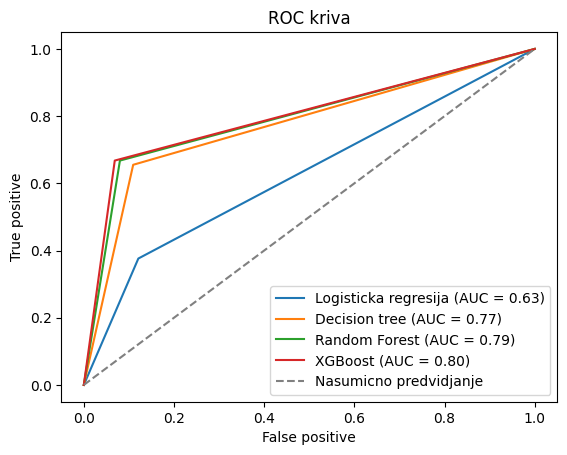

In [632]:
logreg_fpr, logreg_tpr, _ = roc_curve(y_valid, logreg_valid_preds)
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)

dt_fpr, dt_tpr, _ = roc_curve(y_valid, dt_valid_preds)
dt_roc_auc = auc(dt_fpr, dt_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_valid, rf_valid_preds)
rf_roc_auc = auc(rf_fpr, rf_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_valid, xgb_valid_preds)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

print("Povrsina ispod krive logisticke regresije:", logreg_roc_auc)
print("Povrsina ispod krive decision tree:", dt_roc_auc)
print("Povrsina ispod krive random forest:", rf_roc_auc)
print("Povrsina ispod krive Xgboost:", xgb_roc_auc)

#ROC kriva
plt.figure()
plt.plot(logreg_fpr, logreg_tpr, label='Logisticka regresija (AUC = {:.2f})'.format(logreg_roc_auc))
plt.plot(dt_fpr, dt_tpr, label='Decision tree (AUC = {:.2f})'.format(dt_roc_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(rf_roc_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.2f})'.format(xgb_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Nasumicno predvidjanje')
plt.xlabel('False positive')
plt.ylabel('True positive')
plt.title('ROC kriva')
plt.legend()
plt.show()


Jasno se vidi razlika u kvalitetu između različitih modela, i može se zaključiti kako su modeli zaista uspešni u predviđanju otkaza zaposlenog.

## Izbor parametara


Na osnovu hi-kvadratnog testa zaključuje se da je upitan uticaj parametra godina iskustva na uspešnost modela. Zato je potrebno proveriti kvalitet modela kada se ovaj parametar zanemari. Takođe je poželjno proveriti uspešnost nakon zanemarivanja i godina zaposlenog.

In [633]:
x_train = x_train.drop("ExperienceInCurrentDomain", axis=1)
x_valid = x_valid.drop("ExperienceInCurrentDomain", axis=1)


logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

rf_model = RandomForestClassifier(random_state=42,n_estimators=117)
rf_model.fit(x_train, y_train)

xgb_model = xgb.XGBClassifier(random_state=42,n_estimators=150)
xgb_model.fit(x_train, y_train)

logreg_valid_preds = logreg_model.predict(x_valid)
dt_valid_preds = dt_model.predict(x_valid)
rf_valid_preds = rf_model.predict(x_valid)
xgb_valid_preds = xgb_model.predict(x_valid)

print("Preciznost logisticke regresije:", accuracy_score(y_valid, logreg_valid_preds))
print("Preciznost stabla odluke:", accuracy_score(y_valid, dt_valid_preds))
print("Random forest preciznost:", accuracy_score(y_valid, rf_valid_preds))
print("Preciznost Xgboost:", accuracy_score(y_valid, xgb_valid_preds))


Preciznost logisticke regresije: 0.7099892588614393
Preciznost stabla odluke: 0.8313641245972073
Random forest preciznost: 0.8335123523093448
Preciznost Xgboost: 0.8506981740064447


In [634]:
x_train = x_train.drop("Age", axis=1)
x_valid = x_valid.drop("Age", axis=1)


logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

rf_model = RandomForestClassifier(random_state=42,n_estimators=117)
rf_model.fit(x_train, y_train)

xgb_model = xgb.XGBClassifier(random_state=42,n_estimators=150)
xgb_model.fit(x_train, y_train)

logreg_valid_preds = logreg_model.predict(x_valid)
dt_valid_preds = dt_model.predict(x_valid)
rf_valid_preds = rf_model.predict(x_valid)
xgb_valid_preds = xgb_model.predict(x_valid)

print("Preciznost logisticke regresije:", accuracy_score(y_valid, logreg_valid_preds))
print("Preciznost stabla odluke:", accuracy_score(y_valid, dt_valid_preds))
print("Random forest preciznost:", accuracy_score(y_valid, rf_valid_preds))
print("Preciznost Extreme gradient boosting:", accuracy_score(y_valid, xgb_valid_preds))

Preciznost logisticke regresije: 0.6992481203007519
Preciznost stabla odluke: 0.8453276047261009
Random forest preciznost: 0.8485499462943072
Preciznost Extreme gradient boosting: 0.8506981740064447



Vidi se poboljšanje u preciznosti nakon suzavanja izbora validnih parametara. Sada je potrebno proveriti i ostale mere kvaliteta, a zatim i uspešnost nad testnim skupom.

In [635]:
print("Matrica konfuzije logisticke regresije:")
print(confusion_matrix(y_valid, logreg_valid_preds))
print("\nMatrica konfuzije Decision tree")
print(confusion_matrix(y_valid, dt_valid_preds))
print("\nMatrica konfuzije random forest")
print(confusion_matrix(y_valid, rf_valid_preds))
print("\nMatrica konfuzije Xgboost")
print(confusion_matrix(y_valid, xgb_valid_preds))

Matrica konfuzije logisticke regresije:
[[541  71]
 [209 110]]

Matrica konfuzije Decision tree
[[590  22]
 [122 197]]

Matrica konfuzije random forest
[[580  32]
 [109 210]]

Matrica konfuzije Xgboost
[[586  26]
 [113 206]]


In [636]:
print("Izvestaj logisticke regresije:") 
print(classification_report(y_valid, logreg_valid_preds))
print("Izvestaj decision tree:")
print(classification_report(y_valid, dt_valid_preds))
print("Izvestaj random forest:")
print(classification_report(y_valid, rf_valid_preds))
print("Izvestaj Xgboost:")
print(classification_report(y_valid, xgb_valid_preds))

Izvestaj logisticke regresije:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       612
           1       0.61      0.34      0.44       319

    accuracy                           0.70       931
   macro avg       0.66      0.61      0.62       931
weighted avg       0.68      0.70      0.67       931

Izvestaj decision tree:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       612
           1       0.90      0.62      0.73       319

    accuracy                           0.85       931
   macro avg       0.86      0.79      0.81       931
weighted avg       0.85      0.85      0.84       931

Izvestaj random forest:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       612
           1       0.87      0.66      0.75       319

    accuracy                           0.85       931
   macro avg       0.85      0.80      0.82      

In [637]:
print("F1-vrednost logisticke regresije:", f1_score(y_valid, logreg_valid_preds))
print("F1-vrednost decision tree:", f1_score(y_valid, dt_valid_preds))
print("F1-vrednost random forest:", f1_score(y_valid, rf_valid_preds))
print("F1-vrednost Xgboost:", f1_score(y_valid, xgb_valid_preds))

F1-vrednost logisticke regresije: 0.44000000000000006
F1-vrednost decision tree: 0.7323420074349443
F1-vrednost random forest: 0.7486631016042781
F1-vrednost Xgboost: 0.7477313974591652


Povrsina ispod krive logisticke regresije: 0.6144072571557359
Povrsina ispod krive decision tree: 0.7908035732579344
Povrsina ispod krive random forest: 0.8030098141660008
Povrsina ispod krive Xgboost: 0.8016421824738256


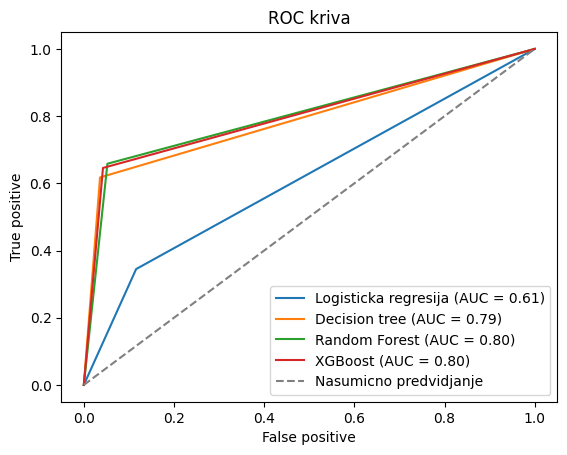

In [638]:
logreg_fpr, logreg_tpr, _ = roc_curve(y_valid, logreg_valid_preds)
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)

dt_fpr, dt_tpr, _ = roc_curve(y_valid, dt_valid_preds)
dt_roc_auc = auc(dt_fpr, dt_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_valid, rf_valid_preds)
rf_roc_auc = auc(rf_fpr, rf_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_valid, xgb_valid_preds)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

print("Povrsina ispod krive logisticke regresije:", logreg_roc_auc)
print("Povrsina ispod krive decision tree:", dt_roc_auc)
print("Povrsina ispod krive random forest:", rf_roc_auc)
print("Povrsina ispod krive Xgboost:", xgb_roc_auc)

#ROC kriva
plt.figure()
plt.plot(logreg_fpr, logreg_tpr, label='Logisticka regresija (AUC = {:.2f})'.format(logreg_roc_auc))
plt.plot(dt_fpr, dt_tpr, label='Decision tree (AUC = {:.2f})'.format(dt_roc_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(rf_roc_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.2f})'.format(xgb_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Nasumicno predvidjanje')
plt.xlabel('False positive')
plt.ylabel('True positive')
plt.title('ROC kriva')
plt.legend()
plt.show()


Primećuje se kako je došlo do poboljšanja modela Decision tree, Xgboost i Random forest.

## Rezultati istrazivanja

### Mere nad test skupom

In [639]:
x_test = x_test.drop("ExperienceInCurrentDomain", axis=1)
x_test = x_test.drop("Age", axis=1)

logreg_test_preds = logreg_model.predict(x_test)
dt_test_preds = dt_model.predict(x_test)
rf_test_preds = rf_model.predict(x_test)
xgb_test_preds = xgb_model.predict(x_test)

print("Preciznost logisticke regresije:", accuracy_score(y_test, logreg_test_preds))
print("Preciznost stabla odluke:", accuracy_score(y_test, dt_test_preds))
print("Random forest preciznost:", accuracy_score(y_test, rf_test_preds))
print("Preciznost Extreme gradient boosting:", accuracy_score(y_test, xgb_test_preds))

Preciznost logisticke regresije: 0.6981740064446831
Preciznost stabla odluke: 0.832438238453276
Random forest preciznost: 0.8292158968850698
Preciznost Extreme gradient boosting: 0.8292158968850698


In [640]:
print("Matrica konfuzije logisticke regresije:")
print(confusion_matrix(y_test, logreg_test_preds))
print("\nMatrica konfuzije Decision tree")
print(confusion_matrix(y_test, dt_test_preds))
print("\nMatrica konfuzije random forest")
print(confusion_matrix(y_test, rf_test_preds))
print("\nMatrica konfuzije Xgboost")
print(confusion_matrix(y_test, xgb_test_preds))

Matrica konfuzije logisticke regresije:
[[541  72]
 [209 109]]

Matrica konfuzije Decision tree
[[584  29]
 [127 191]]

Matrica konfuzije random forest
[[573  40]
 [119 199]]

Matrica konfuzije Xgboost
[[576  37]
 [122 196]]


In [641]:
print("Izvestaj logisticke regresije:") 
print(classification_report(y_test, logreg_test_preds))
print("Izvestaj decision tree:")
print(classification_report(y_test, dt_test_preds))
print("Izvestaj random forest:")
print(classification_report(y_test, rf_test_preds))
print("Izvestaj Xgboost:")
print(classification_report(y_test, xgb_test_preds))

Izvestaj logisticke regresije:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79       613
           1       0.60      0.34      0.44       318

    accuracy                           0.70       931
   macro avg       0.66      0.61      0.62       931
weighted avg       0.68      0.70      0.67       931

Izvestaj decision tree:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       613
           1       0.87      0.60      0.71       318

    accuracy                           0.83       931
   macro avg       0.84      0.78      0.80       931
weighted avg       0.84      0.83      0.82       931

Izvestaj random forest:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       613
           1       0.83      0.63      0.71       318

    accuracy                           0.83       931
   macro avg       0.83      0.78      0.80      

In [642]:
print("F1-vrednost logisticke regresije:", f1_score(y_test, logreg_test_preds))
print("F1-vrednost decision tree:", f1_score(y_test, dt_test_preds))
print("F1-vrednost random forest:", f1_score(y_test, rf_test_preds))
print("F1-vrednost Xgboost:", f1_score(y_test, xgb_test_preds))

F1-vrednost logisticke regresije: 0.43687374749499
F1-vrednost decision tree: 0.7100371747211895
F1-vrednost random forest: 0.7145421903052065
F1-vrednost Xgboost: 0.7114337568058076


Povrsina ispod krive logisticke regresije: 0.612656078467584
Povrsina ispod krive decision tree: 0.7766603055393108
Povrsina ispod krive random forest: 0.7802666543548072
Povrsina ispod krive Xgboost: 0.7779966552781967


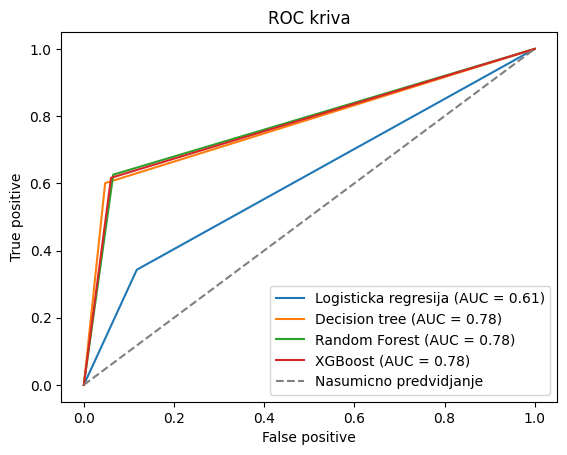

In [643]:
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_test_preds)
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_test_preds)
dt_roc_auc = auc(dt_fpr, dt_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_test_preds)
rf_roc_auc = auc(rf_fpr, rf_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_test_preds)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

print("Povrsina ispod krive logisticke regresije:", logreg_roc_auc)
print("Povrsina ispod krive decision tree:", dt_roc_auc)
print("Povrsina ispod krive random forest:", rf_roc_auc)
print("Povrsina ispod krive Xgboost:", xgb_roc_auc)

#ROC kriva
plt.figure()
plt.plot(logreg_fpr, logreg_tpr, label='Logisticka regresija (AUC = {:.2f})'.format(logreg_roc_auc))
plt.plot(dt_fpr, dt_tpr, label='Decision tree (AUC = {:.2f})'.format(dt_roc_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(rf_roc_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.2f})'.format(xgb_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Nasumicno predvidjanje')
plt.xlabel('False positive')
plt.ylabel('True positive')
plt.title('ROC kriva')
plt.legend()
plt.show()

Modeli daju dobre mere za predviđanje otkaza nad testnim skupom.

### Uticaj parametara


Klasifikacioni algoritmi takođe daju rezultate koji pokazuju koliki uticaj je svaki parametar imao na konačnu predikciju.

<Figure size 640x480 with 0 Axes>

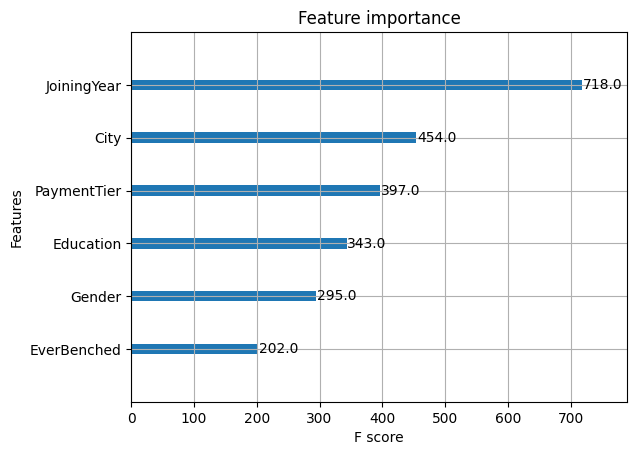

In [644]:
plt.figure()
plot_importance(xgb_model) #group by joiningYear i City
plt.show()

In [645]:
indices = sorted(range(len(rf_model.feature_importances_)), key=rf_model.feature_importances_.__getitem__, reverse=True)

print("Feature importance:")
for i in range(len(rf_model.feature_importances_)):
    print(f"{i + 1}. Feature {list(x_train.columns)[indices[i]]}: {rf_model.feature_importances_[indices[i]]}")

Feature importance:
1. Feature JoiningYear: 0.4047675756760557
2. Feature PaymentTier: 0.16319951743071923
3. Feature City: 0.1593701684007969
4. Feature Education: 0.14264535149798174
5. Feature Gender: 0.11122525068753016
6. Feature EverBenched: 0.018792136306916295


### Analiza podataka

Hi-kvadratni test i poboljšanje kvaliteta modela potvrdili su uravnotežen odnos otkaza po godinama radnika i njihovom iskustvu, tako da u prisustvu drugih parametara nisu toliko korisni. Podaci koji su najznačajniji poslodavcima su sledeći:

Žene su naklonjenije davanju otkaza.

Veliki je procenat otkaza zaposlenih sa masterom i srednjim nivoom plate.

Prirastaj radnika 2018. godine je bio skoro pa sasvim neuspešan.

Radnici koji su se zaposlili 2015. godine su takođe nezadovoljni, a većina ih je bila zaposlena u Puni, što je dovelo do velikog broja otkaza u tom gradu.

Ovi podaci ukazuju na potrebu dodatne analize rada u kompaniji kako bi se problem otkaza zaposlenih rešio.

### Upoređivanje kvaliteta istrazivanja

Najbolju preciznost od 83,24% postiže model Decision Tree za izabranu podelu podataka na trening, test i validacioni skup.

Na sajtu https://www.kaggle.com/ se mogu naći mnogi radovi koji su koristili isti skup podataka, tako da se mogu međusobno uporediti efikasnosti modela. Sledi poređenje rezultata istraživanja sa četiri trenutno najbolje ocenjena rada sa sajta, pri čemu postoji mogućnost blagih razlika usled različitog izbora metode podele podataka za analizu.

1. https://www.kaggle.com/code/kareemellithy/employee-data-visualization-svm : Preciznost 64,98%

2. https://www.kaggle.com/code/aagyapalkaur/absolutebeginners-eda-employeeleaveornot : Preciznost 78,92%

3. https://www.kaggle.com/code/raman209/employee-data-classification : Preciznost 84,96%

4. https://www.kaggle.com/code/octavianwr/employee-churn-dibimbing-id : Preciznost 68,16%

## Reference

## Dodatak